<a href="https://colab.research.google.com/github/Nive-1515/Applied-AI/blob/main/AAI%20REC(23).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

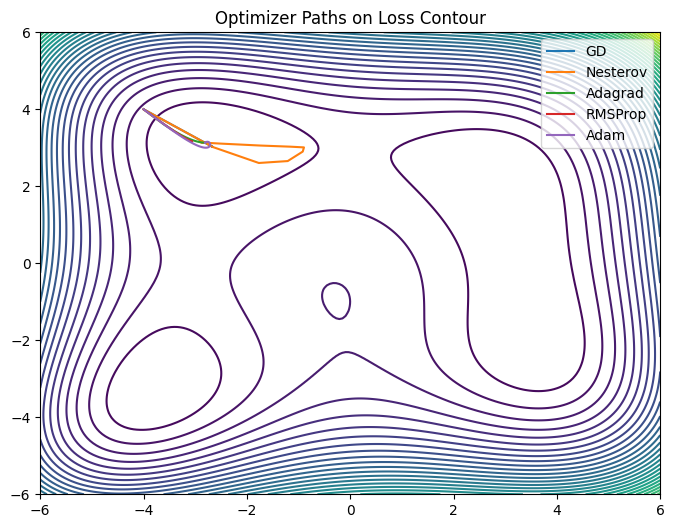

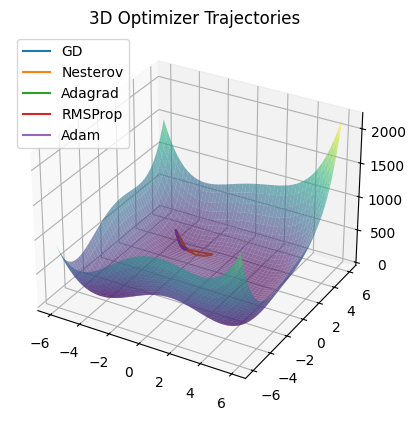

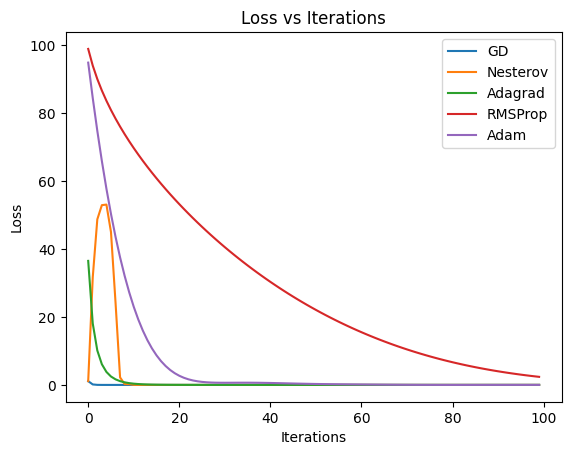

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Final w: [-2.4880562 -2.360394 ]
Final loss: 0.16879067


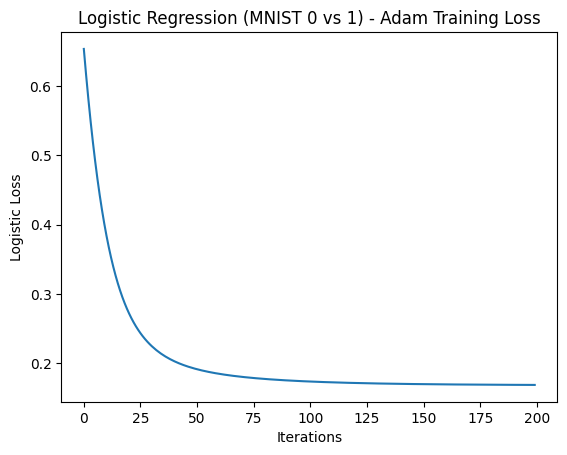

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# -----------------------------
# Part A: Optimizers on Himmelblau-like function
# -----------------------------
def J(w):
    w1, w2 = w
    return (w1**2 + w2 - 11)**2 + (w1 + w2**2 - 7)**2

def grad_J(w):
    w1, w2 = w
    dw1 = 4*w1*(w1**2 + w2 - 11) + 2*(w1 + w2**2 - 7)
    dw2 = 2*(w1**2 + w2 - 11) + 4*w2*(w1 + w2**2 - 7)
    return np.array([dw1, dw2], dtype=float)

def GD(init, lr=0.01, steps=100):
    w = init.astype(float).copy()
    path = [w.copy()]
    loss = []
    for _ in range(steps):
        w -= lr * grad_J(w)
        path.append(w.copy())
        loss.append(J(w))
    return np.array(path), loss

def Nesterov(init, lr=0.01, gamma=0.9, steps=100):
    w = init.astype(float).copy()
    v = np.zeros_like(w)
    path = [w.copy()]
    loss = []
    for _ in range(steps):
        lookahead = w - gamma * v
        g = grad_J(lookahead)
        v = gamma * v + lr * g
        w -= v
        path.append(w.copy())
        loss.append(J(w))
    return np.array(path), loss

def Adagrad(init, lr=0.4, steps=100):
    w = init.astype(float).copy()
    G = np.zeros_like(w)
    eps = 1e-8
    path = [w.copy()]
    loss = []
    for _ in range(steps):
        g = grad_J(w)
        G += g**2
        w -= lr * g / (np.sqrt(G) + eps)
        path.append(w.copy())
        loss.append(J(w))
    return np.array(path), loss

def RMSProp(init, lr=0.01, beta=0.9, steps=100):
    w = init.astype(float).copy()
    Eg = np.zeros_like(w)
    eps = 1e-8
    path = [w.copy()]
    loss = []
    for _ in range(steps):
        g = grad_J(w)
        Eg = beta * Eg + (1 - beta) * (g**2)
        w -= lr * g / (np.sqrt(Eg) + eps)
        path.append(w.copy())
        loss.append(J(w))
    return np.array(path), loss

def Adam(init, lr=0.05, steps=100, b1=0.9, b2=0.999):
    w = init.astype(float).copy()
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    eps = 1e-8
    path = [w.copy()]
    loss = []
    for t in range(1, steps + 1):
        g = grad_J(w)
        m = b1 * m + (1 - b1) * g
        v = b2 * v + (1 - b2) * (g**2)
        mhat = m / (1 - b1**t)
        vhat = v / (1 - b2**t)
        w -= lr * mhat / (np.sqrt(vhat) + eps)
        path.append(w.copy())
        loss.append(J(w))
    return np.array(path), loss

init = np.array([-4.0, 4.0])
optimizers = {
    "GD": GD,
    "Nesterov": Nesterov,
    "Adagrad": Adagrad,
    "RMSProp": RMSProp,
    "Adam": Adam,
}

paths, losses = {}, {}
for name, opt in optimizers.items():
    paths[name], losses[name] = opt(init)

x = np.linspace(-6, 6, 200)
y = np.linspace(-6, 6, 200)
Xg, Yg = np.meshgrid(x, y)
Z = J([Xg, Yg])

# 2D contour + optimizer paths
plt.figure(figsize=(8, 6))
plt.contour(Xg, Yg, Z, 40)
for name, p in paths.items():
    plt.plot(p[:, 0], p[:, 1], label=name)
plt.legend()
plt.title("Optimizer Paths on Loss Contour")
plt.show()

# 3D surface + trajectories
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(Xg, Yg, Z, cmap=cm.viridis, alpha=0.6)
for name, p in paths.items():
    ztraj = np.array([J(w) for w in p])
    ax.plot(p[:, 0], p[:, 1], ztraj, label=name)
ax.set_title("3D Optimizer Trajectories")
ax.legend()
plt.show()

# Loss curves
plt.figure()
for name, l in losses.items():
    plt.plot(l, label=name)
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Iterations")
plt.show()

# -----------------------------
# Part B: Logistic Regression (MNIST 0 vs 1) with Adam
# -----------------------------
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()

mask = (y_train == 0) | (y_train == 1)
x = x_train[mask].astype(np.float32)
y = y_train[mask].astype(np.float32)

# Make labels strictly 0/1 (MNIST already 0 and 1, but keep safe)
y = (y == 1).astype(np.float32)

x = x.reshape(len(x), -1)

# Two simple features from halves of the flattened image
f1 = x[:, :392].mean(axis=1)
f2 = x[:, 392:].mean(axis=1)
X = np.vstack((f1, f2)).T
X = StandardScaler().fit_transform(X).astype(np.float32)

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def loss_lr(w):
    p = sigmoid(X.dot(w))
    eps = 1e-8
    return -np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))

def grad_lr(w):
    # gradient of logistic loss w.r.t w (no bias term here)
    p = sigmoid(X.dot(w))
    return (X.T.dot(p - y)) / len(y)

def train_adam_lr(steps=200, lr=0.05, b1=0.9, b2=0.999):
    w = np.zeros(2, dtype=np.float32)
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    eps = 1e-8
    path = [w.copy()]
    losses_list = []
    for t in range(1, steps + 1):
        g = grad_lr(w)
        m = b1 * m + (1 - b1) * g
        v = b2 * v + (1 - b2) * (g**2)
        mhat = m / (1 - b1**t)
        vhat = v / (1 - b2**t)
        w -= lr * mhat / (np.sqrt(vhat) + eps)
        path.append(w.copy())
        losses_list.append(loss_lr(w))
    return np.array(path), losses_list

path_lr, loss_lr_vals = train_adam_lr()

print("Final w:", path_lr[-1])
print("Final loss:", loss_lr_vals[-1])

plt.figure()
plt.plot(loss_lr_vals)
plt.xlabel("Iterations")
plt.ylabel("Logistic Loss")
plt.title("Logistic Regression (MNIST 0 vs 1) - Adam Training Loss")
plt.show()